# [dont-overfit-ii](https://www.kaggle.com/c/dont-overfit-ii)

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.decomposition import PCA
#import plotly.graph_objs as go
from sklearn import datasets

import matplotlib.pyplot as plt
#import plotly.plotly as py
import seaborn as sns
#import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib
import warnings
import pathlib
import sklearn
import scipy
import numpy
import json
import sys
import csv
import os

warnings.filterwarnings('ignore')
sns.set(color_codes=True)
plt.style.available
%matplotlib inline
%precision 2

print('Python:     {}'.format(sys.version))
print('numpy:      {}'.format(np.__version__))
print('pandas:     {}'.format(pd.__version__))
print('sklearn:    {}'.format(sklearn.__version__))
print('scipy:      {}'.format(scipy.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn:    {}'.format(sns.__version__))

Python:     3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
numpy:      1.15.4
pandas:     0.24.1
sklearn:    0.20.1
scipy:      1.1.0
matplotlib: 3.0.2
seaborn:    0.9.0


In [2]:
path = pathlib.Path("E:/Datasets/Kaggle/Dont-overfit-ii")

train = pd.read_csv(path / 'train.csv')
test  = pd.read_csv(path / 'test.csv')
subm  = pd.read_csv(path / 'sample_submission.csv')

print("Train:", train.shape)
print("Test:", test.shape)
train.head()

Train: (250, 302)
Test: (19750, 301)


,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [3]:
# we have no missing values
train.isnull().any().any()

False

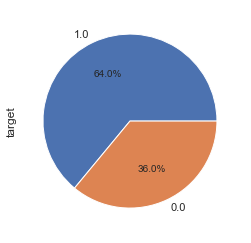

In [4]:
train['target'].value_counts().plot.pie(autopct='%1.1f%%');

### Let's have a look at correlations now!
We can see that correlations between features are lower that 0.3 and the most correlated feature with target has correlation of 0.37. So we have no highly correlated features which we could drop, on the other hand we could drop some columns with have little correlation with the target.

In [5]:
corrs = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
90892,22,28,0.246062
90893,28,22,0.246062
90894,193,101,0.252825
90895,101,193,0.252825
90896,75,32,0.259315
90897,32,75,0.259315
90898,target,65,0.293846
90899,65,target,0.293846
90900,33,target,0.373608
90901,target,33,0.373608


# Models

In [6]:
from sklearn.tree         import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [7]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test  = test.drop(['id'], axis=1)

n_fold = 50
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

parameter_grid = {'class_weight': ['balanced', None],
                  'penalty':      ['l2'],
                  'C':            [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                  'solver':       ['newton-cg', 'sag', 'lbfgs']
                 }

grid_search = GridSearchCV(model, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7803333333333332
Best parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}


In [43]:
parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2', 'l1'],
                  'C' : [0.001, 0.01, 0.05, 0.08, 0.1, 0.15, 1.0, 10.0],
                 }

grid_search = GridSearchCV(model, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.819
Best parameters: {'C': 0.08, 'class_weight': None, 'penalty': 'l1'}


In [44]:
param_grid = {'class_weight': ['balanced', None], 
              'penalty':      ['l2','l1'],  
              'C':            [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train,y_train)
print("Best Score:", grid.best_score_)
print("Best Parameters:", grid.best_params_)

Best Score: 0.8069269042627533
Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}


# 5. Train best model

In [9]:
#model = LogisticRegression(**best_parameters)
#model = LogisticRegression(class_weight=None, penalty='l1', C=0.8, solver='liblinear')       # 0.732
model = LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')  # 0.849
model.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

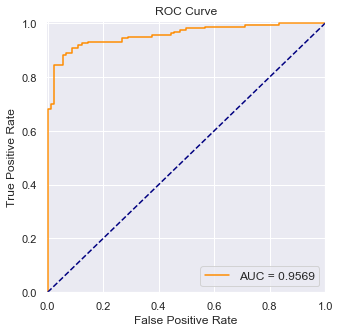

In [36]:
def plot_roc(y_valid, y_pred, ax=None, figsize=(5,5)):

    if ax is None: fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    fpr, tpr, threshold = metrics.roc_curve(y_valid, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    ax.set_title('ROC Curve')
    ax.plot(fpr, tpr, 'darkorange', label = 'AUC = %0.4f' % roc_auc)
    ax.legend(loc = 'lower right', fontsize="large")
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.set_xlim([-0.005, 1])
    ax.set_ylim([0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    return ax

y_pred = model.predict_proba(X_train)[:,1]
plot_roc(y_train, y_pred);
#y_train.shape, y_pred.shape

# 6. Recursive Feature Elimination

In [34]:
from sklearn.feature_selection import RFE

selector = RFE(model, 25, step=1)
selector.fit(X_train,y_train)

RFE(estimator=LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  n_features_to_select=25, step=1, verbose=0)

# 7. Predicct submmision

In [52]:
subm["target"] = selector.predict_proba(X_test)[:,1]  # Probabilities (floar)
#subm["target"] = model.predict(X_test).astype(int) # 0 or 1 (int) (BAD FOR AUC SCORE!!!!)
subm.head()

,id,target
0,250,0.689193
1,251,0.466148
2,252,0.535808
3,253,0.779195
4,254,0.427526


In [53]:
subm.to_csv("mySub.csv", index=False)